In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [22]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

**This numpy file contains images with details of bounding boxes. We have total 409 images.**

In [4]:
data = np.load("/content/drive/My Drive/Colab Notebooks/face mask/images.npy",allow_pickle=True)

**lets see the format of the npy file we have. Lets see the 111th image:**

In [5]:
print(data[111])

[array([[[200, 186, 173],
        [198, 186, 172],
        [197, 188, 173],
        ...,
        [135, 139,  54],
        [138, 141,  54],
        [135, 138,  49]],

       [[200, 188, 174],
        [197, 188, 173],
        [196, 187, 172],
        ...,
        [136, 138,  54],
        [142, 144,  60],
        [142, 141,  58]],

       [[194, 185, 168],
        [196, 187, 172],
        [199, 187, 173],
        ...,
        [139, 140,  60],
        [142, 141,  61],
        [143, 142,  62]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 99, 111, 137],
        [ 93, 100, 126],
        [ 84,  91, 117]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 99, 113, 139],
        [ 92, 102, 129],
        [ 81,  88, 114]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 98, 114, 139],
        [ 94, 105, 133],
        [ 89,  99, 126]

**We have 5 faces (bounding box coordinates) in this image:**

In [6]:
#we have 5 faces in the 111th image
for i in data[111][1]:
  print(i["points"][0])
  print(i["points"][1])
  print("")

{'x': 0.06611570247933884, 'y': 0.07131782945736434}
{'x': 0.256198347107438, 'y': 0.40310077519379844}

{'x': 0.2871900826446281, 'y': 0.16744186046511628}
{'x': 0.4318181818181818, 'y': 0.43410852713178294}

{'x': 0.4287190082644628, 'y': 0.06821705426356589}
{'x': 0.6084710743801653, 'y': 0.3689922480620155}

{'x': 0.5619834710743802, 'y': 0.21395348837209302}
{'x': 0.7252066115702479, 'y': 0.49147286821705427}

{'x': 0.7737603305785123, 'y': 0.21705426356589147}
{'x': 0.9421487603305785, 'y': 0.5441860465116279}



**Lets see other few images and put a bounding box on the faces:**

10th image


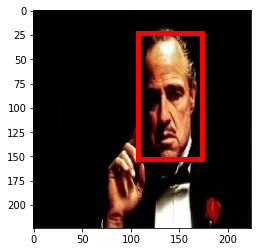

18th image


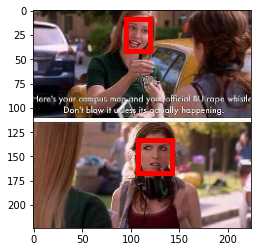

7th image


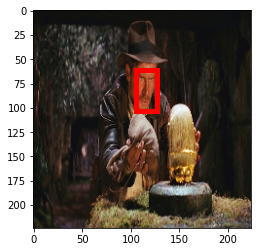

111th image


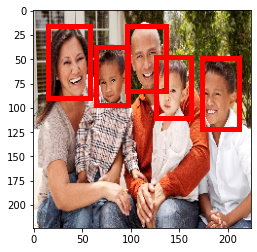

77th image


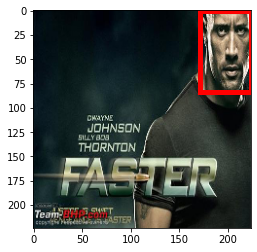

In [7]:
for image in [10,18,7,111,77]:
  
  fig,ax = plt.subplots(1)
  print(str(image)+"th image")
  ax.imshow(cv2.resize(data[image][0], dsize=(224, 224), interpolation=cv2.INTER_CUBIC))
  
  for faces in data[image][1]:
    x1 = faces["points"][0]['x']
    y1 = faces["points"][0]['y']
    x2 = faces["points"][1]['x']
    y2 = faces["points"][1]['y']
    rect = patches.Rectangle((x1*224, y1*224), (x2-x1)*224, (y2-y1)*224, linewidth=5, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

  plt.show()

In [7]:
img_w = 224
img_h = 224

**Here we will create a mask array which will be the labels. Each mask is a label, We have to predict this mask. To create the mask we will scale the BB coordinates wrt 224x224 since the input to our model (mobilenet) will be 224x224 image. After resizing the images to 224x224 we will also pass it to the preprocess_input function of the mobilenet.**

In [8]:
masks = np.zeros((int(data.shape[0]), img_h, img_w))
X = np.zeros((int(data.shape[0]), img_h, img_w, 3))

for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(img_h, img_w), interpolation=cv2.INTER_CUBIC)
    
    try:
      img = img[:, :, :3]
    except:
      continue

    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * img_w)
        x2 = int(i["points"][1]['x'] * img_w)
        y1 = int(i["points"][0]['y'] * img_h)
        y2 = int(i["points"][1]['y'] * img_h)
        masks[index][y1:y2, x1:x2] = 1

**Splitting the data into training and testing set**
- 400 images in training set
- 9 images in testing set

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, masks, test_size=9, random_state=1111)

print("training set images: ",x_train.shape)
print("testing set images: ",x_val.shape)

training set images:  (400, 224, 224, 3)
testing set images:  (9, 224, 224, 3)


**Lets look at some images and their masks in the training set. Above we saw some images and their masks in bounding box format. Here we will see in mask format.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


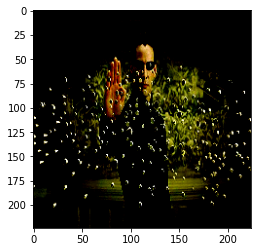

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


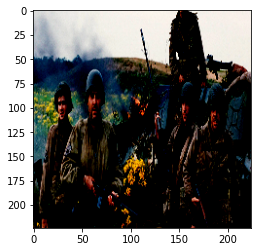

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


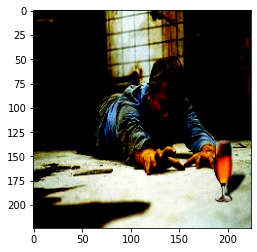

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


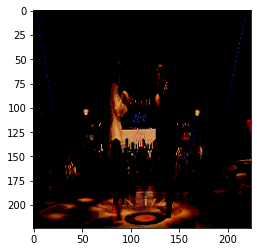

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


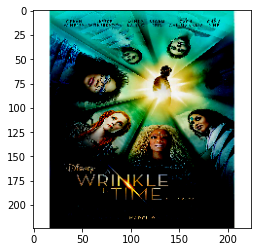

In [ ]:
for i in [7,77,11,111,10]:
  fig,ax = plt.subplots(1)
  ax.imshow(x_train[i])
  plt.show()

**Their corresponding masks:**

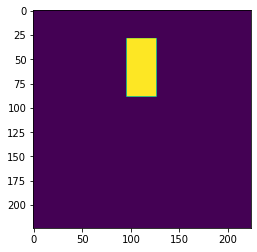

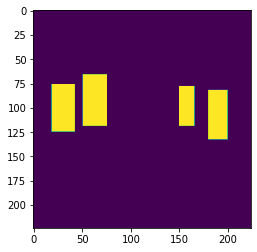

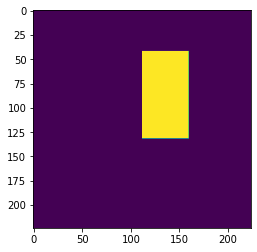

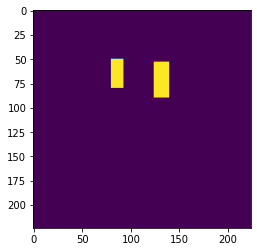

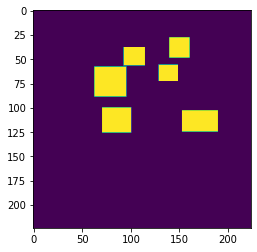

In [ ]:
for i in [7,77,11,111,10]:
  fig,ax = plt.subplots(1)
  ax.imshow(y_train[i])
  plt.show()

# How the network looks like:
**We are using the complete (alpha=1) MobileNet Architecture. Since its trained on imagenet hence we will not include the top classifier part and instead put our U-Net architecture.**<br>
Below is the picture summary of the architecture. The downsampling part is the mobilenet part. In the image we have depicted "convolution block" of the mobilenet architecture. This convolution block is not just a simple convolution layer. Each block has a set of convolution and other layers.<br>Eg: In Convblock 1 we start with a convolution layer that downsamples the feature maps to 112x112 from 224x224 input. Then this block has a batchnorm layer, then a relu layer, then depthwise convolution layer, then again a batchnorm layer, again relu, then pointwise convolution, then batchnorm, then relu.<br> From here we go to convblock 2 at which we again downsample to 56x56. Again, Convblock 2 is not just a single layer but a bunch of different layers. **You can see every layer in each block in the model summary below.**<br><br>
Upsampling is pretty straightforward. We perform upsampling2D and concatinate it with the outputs of the respective blocks as shown in the image.

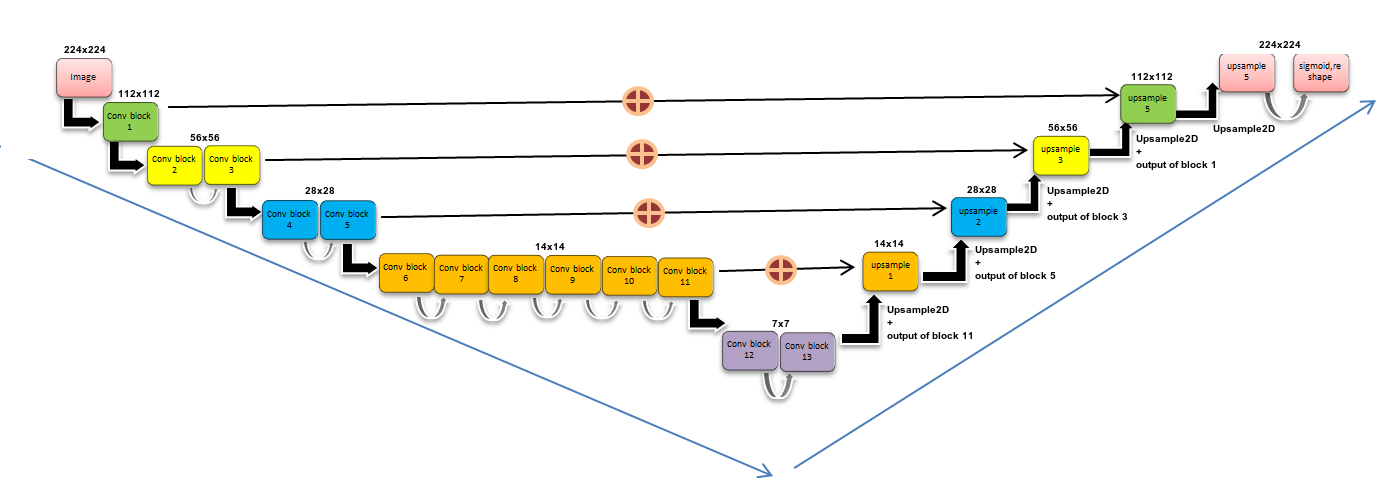

**Note: If you are not able to see the image please find u_net.png in the same directory.<br><br>Lets code this architecture. In first part we will not train the mobilenet network and only train our U-Net architecture. Hence, trainable=False.**

In [ ]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(img_h, img_w, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    #taking the featmaps of last conv layer(pointwise conv layer) of each block to concatinate 
    convblock1 = model.get_layer("conv_pw_1_relu").output 
    convblock3 = model.get_layer("conv_pw_3_relu").output
    convblock5 = model.get_layer("conv_pw_5_relu").output
    convblock11 = model.get_layer("conv_pw_11_relu").output
    convblock13 = model.get_layer("conv_pw_13_relu").output

    #upsampling block 13 output and concatinating last layer(pointwise conv layer) of block 11 
    x = Concatenate()([UpSampling2D()(convblock13), convblock11])

    #upsampling result of above output and concatinating last layer(pointwise conv layer) of block 5
    x = Concatenate()([UpSampling2D()(x), convblock5])

    #upsampling result of above output and concatinating last layer(pointwise conv layer) of block 3
    x = Concatenate()([UpSampling2D()(x), convblock3])

    #upsampling result of above output and concatinating last layer(pointwise conv layer) of block 1
    x = Concatenate()([UpSampling2D()(x), convblock1])

    #simple upsampling of above output (no concatination)
    x = UpSampling2D()(x)

    #applying 1x1 conv with sigmoid activation (each pixel)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    #reshaping
    x = Reshape((img_h, img_w))(x)

    return Model(inputs=model.input, outputs=x)

### Part 1
**trainable = False as argument, to freeze the mobilenet layers for fast training.**

In [ ]:
model = create_model(False)

17227776/17225924 [==============================] - 0s 0us/step


**You can see the layers in each conv block in this summary:**

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

**Defining Dice Coefficient function:**

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

**Defining loss function:**

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

**Compiling the model:**

In [ ]:
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

**Defining callbacks:**

In [ ]:
checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor='loss', min_delta=0.01, patience=50, verbose=1, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_dice_coefficient', factor=0.1, patience=20, verbose=1, mode='max', min_delta=0.01, cooldown=5, min_lr=1e-6)

**Lets train the model:**

In [ ]:
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=1000, batch_size=8, verbose=1,callbacks=[stop,reduce_lr,checkpoint])

Epoch 1/1000
50/50 [==============================] - ETA: 0s - loss: 0.5032 - dice_coefficient: 0.7248
Epoch 00001: val_loss improved from inf to 0.92298, saving model to model-0.92.h5
50/50 [==============================] - 9s 184ms/step - loss: 0.5032 - dice_coefficient: 0.7248 - val_loss: 0.9230 - val_dice_coefficient: 0.5997
Epoch 2/1000
50/50 [==============================] - ETA: 0s - loss: 0.5083 - dice_coefficient: 0.7232
Epoch 00002: val_loss improved from 0.92298 to 0.90868, saving model to model-0.91.h5
50/50 [==============================] - 9s 184ms/step - loss: 0.5083 - dice_coefficient: 0.7232 - val_loss: 0.9087 - val_dice_coefficient: 0.6043
Epoch 3/1000
50/50 [==============================] - ETA: 0s - loss: 0.5115 - dice_coefficient: 0.7202
Epoch 00003: val_loss improved from 0.90868 to 0.89393, saving model to model-0.89.h5
50/50 [==============================] - 9s 187ms/step - loss: 0.5115 - dice_coefficient: 0.7202 - val_loss: 0.8939 - val_dice_coefficient: 

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/model.h5")
model.save_weights("/content/drive/My Drive/Colab Notebooks/model_weights.h5")

In [ ]:
hist_df = pd.DataFrame(model.history.history) 
hist_df.to_csv('/content/drive/My Drive/Colab Notebooks/model_history.csv',index=False)

**Evaluating the model on the test set:**

In [ ]:
model.evaluate(x_val, y_val)

1/1 [==============================] - 0s 1ms/step - loss: 0.8742 - dice_coefficient: 0.6416


[0.874229907989502, 0.6415895223617554]

**Dice Coefficient of 0.6416 on test set**<br><br>
**Lets see the training process:**

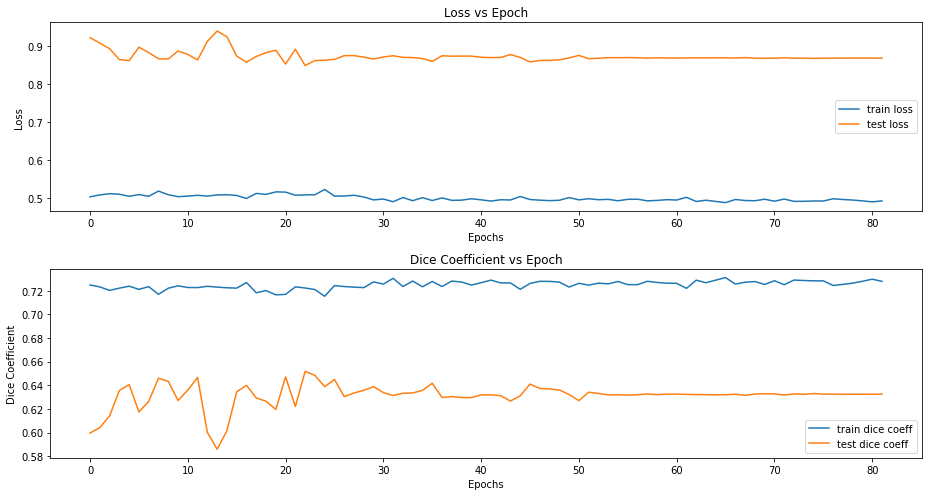

In [ ]:
loss = hist_df['loss']
acc = hist_df['dice_coefficient']
val_loss = hist_df['val_loss']
val_acc = hist_df['val_dice_coefficient']
epoch = hist_df.shape[0]

figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 7))

axes[0].plot(range(0,epoch), loss, label="train loss")
axes[0].plot(range(0,epoch), val_loss, label="test loss")
axes[0].set_title("Loss vs Epoch")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(range(0,epoch), acc, label="train dice coeff")
axes[1].plot(range(0,epoch), val_acc, label="test dice coeff")
axes[1].set_title("Dice Coefficient vs Epoch")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Dice Coefficient")
axes[1].legend()

figure.show()
plt.tight_layout()

**Lets predict the mask for image number 7 from the test set:**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


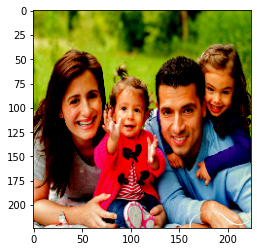

In [ ]:
fig,ax = plt.subplots()
ax.imshow(x_val[7])
plt.show()

**Original mask for image 7:**

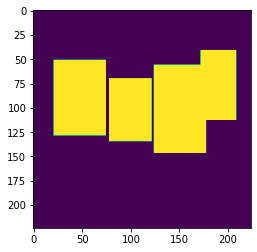

In [ ]:
fig,ax = plt.subplots()
ax.imshow(y_val[7])
plt.show()

**Predicted mask for image 7:**

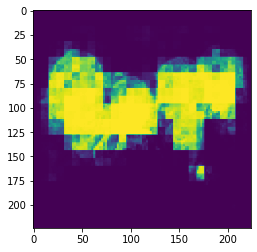

In [ ]:
predicted_mask = model.predict(x_val[7].reshape(1,img_h, img_w,3))
fig,ax = plt.subplots(1)
ax.imshow(predicted_mask.reshape(img_h, img_w))
plt.show()

**Lets predict maks for all the test images and impose them on the orignal images. We have total 9 images in the test set:**

In [ ]:
pred_masks = model.predict(x_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


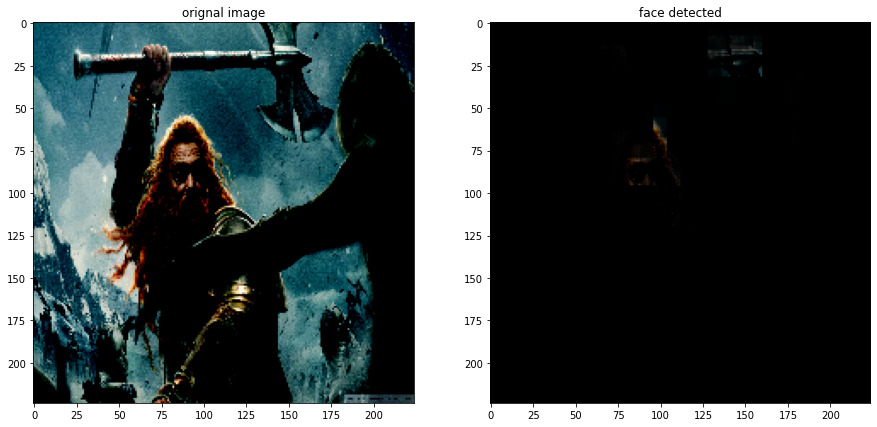

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


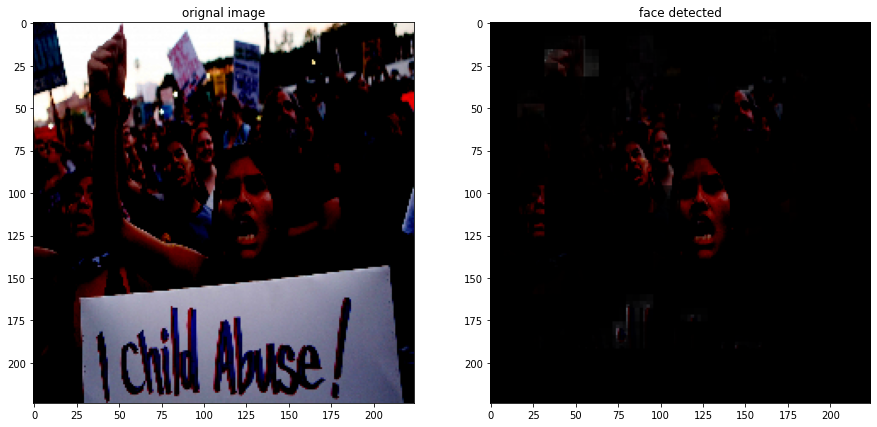

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


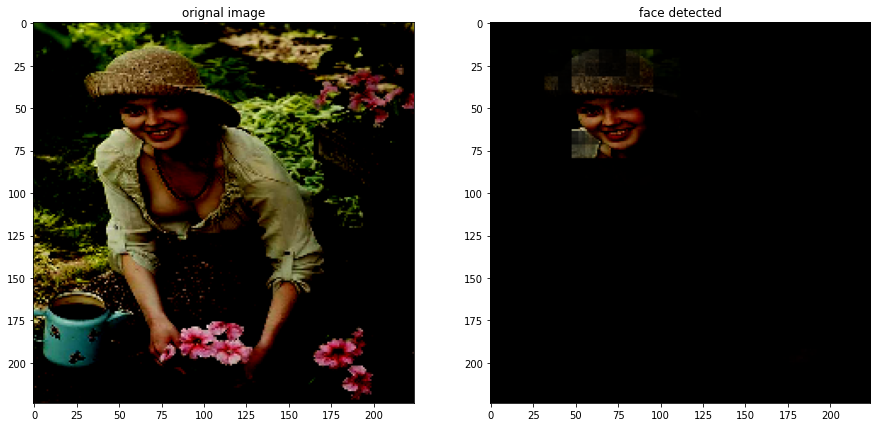

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


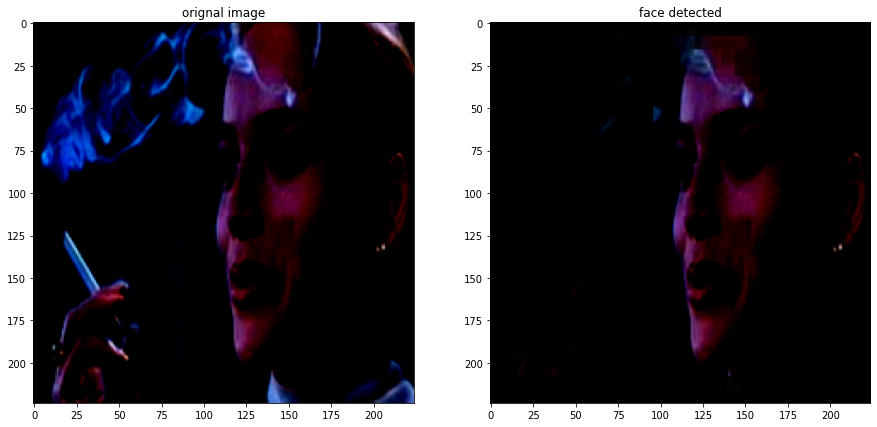

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


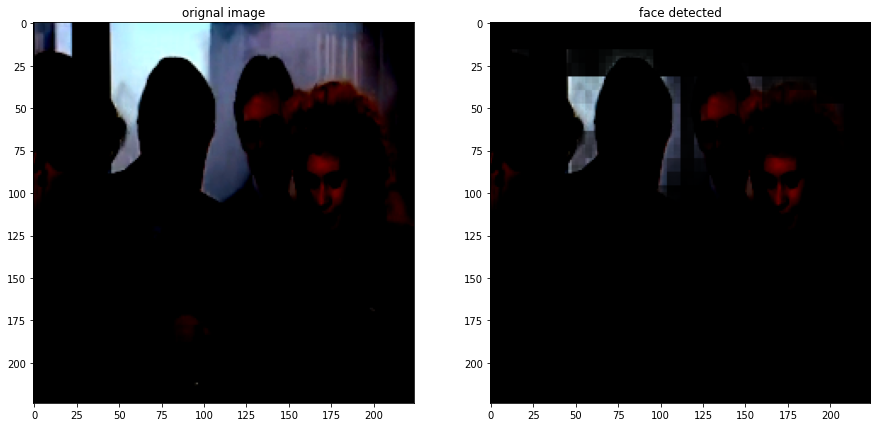

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


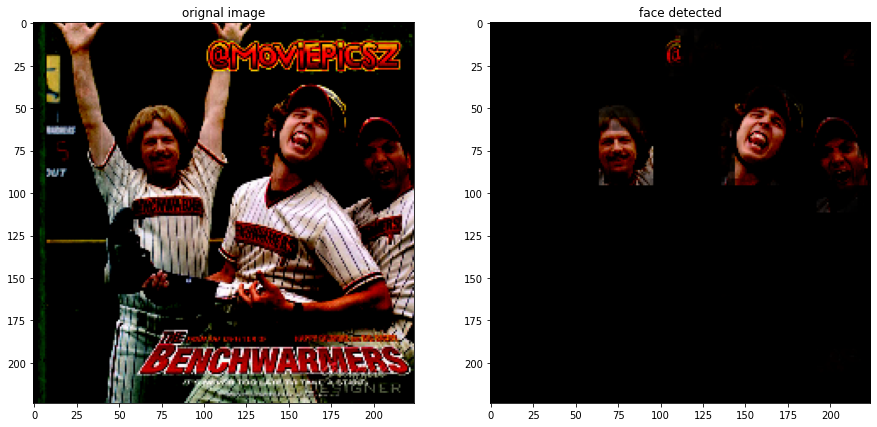

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


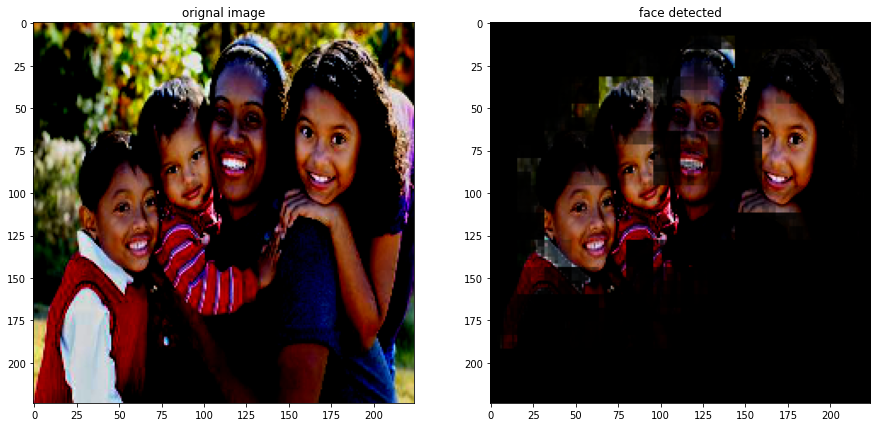

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


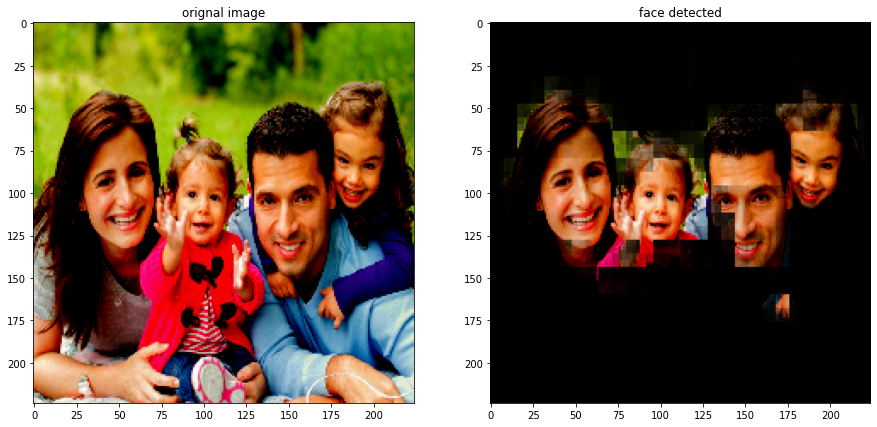

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


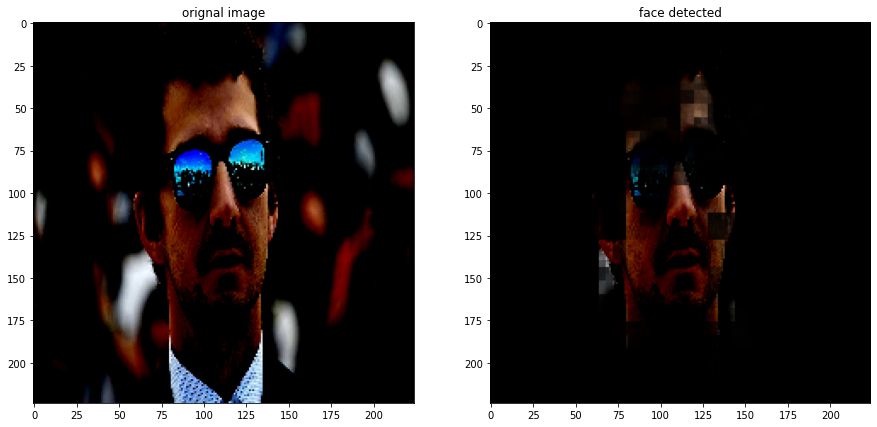

In [ ]:
for i in range(len(pred_masks)):

  fig,ax = plt.subplots(nrows=1, ncols=2,figsize=(15,7))
  ax[0].imshow(x_val[i])
  ax[0].set_title("orignal image")

  x_val[i][:,:,0] = pred_masks[i]*x_val[i][:,:,0]
  x_val[i][:,:,1] = pred_masks[i]*x_val[i][:,:,1]
  x_val[i][:,:,2] = pred_masks[i]*x_val[i][:,:,2] 

  out_image = x_val[i]

  ax[1].imshow(out_image)
  ax[1].set_title("face detected")
  plt.show()

**If you are not able to see the output of the above cell, please run this notebook in google colab**

### Part 2
**We will now train again with trainable=True i.e we will also train the mobilenet network.**

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, masks, test_size=9, random_state=1111)

print("training set images: ",x_train.shape)
print("testing set images: ",x_val.shape)

training set images:  (400, 224, 224, 3)
testing set images:  (9, 224, 224, 3)


In [ ]:
model = create_model(True)
model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
______________________________________________________________________________________

In [ ]:
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=1000, batch_size=8, verbose=1,callbacks=[stop,reduce_lr,checkpoint])

Epoch 1/1000
50/50 [==============================] - ETA: 0s - loss: 1.0593 - dice_coefficient: 0.5498
Epoch 00001: val_loss improved from inf to 3.27907, saving model to model-3.28.h5
50/50 [==============================] - 19s 386ms/step - loss: 1.0593 - dice_coefficient: 0.5498 - val_loss: 3.2791 - val_dice_coefficient: 0.2398
Epoch 2/1000
50/50 [==============================] - ETA: 0s - loss: 0.6345 - dice_coefficient: 0.6688
Epoch 00002: val_loss improved from 3.27907 to 1.53490, saving model to model-1.53.h5
50/50 [==============================] - 18s 367ms/step - loss: 0.6345 - dice_coefficient: 0.6688 - val_loss: 1.5349 - val_dice_coefficient: 0.4465
Epoch 3/1000
50/50 [==============================] - ETA: 0s - loss: 0.5173 - dice_coefficient: 0.7119
Epoch 00003: val_loss improved from 1.53490 to 0.96132, saving model to model-0.96.h5
50/50 [==============================] - 18s 361ms/step - loss: 0.5173 - dice_coefficient: 0.7119 - val_loss: 0.9613 - val_dice_coefficien

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/model.h5")
model.save_weights("/content/drive/My Drive/Colab Notebooks/model_weights.h5")

hist_df = pd.DataFrame(model.history.history) 
hist_df.to_csv('/content/drive/My Drive/Colab Notebooks/model_history.csv',index=False)

In [ ]:
model.evaluate(x_val, y_val)

1/1 [==============================] - 0s 2ms/step - loss: 0.9090 - dice_coefficient: 0.6722


[0.9090425968170166, 0.6721689701080322]

**Dice Coefficient improved to 0.6722 from 0.6416 in part 1**

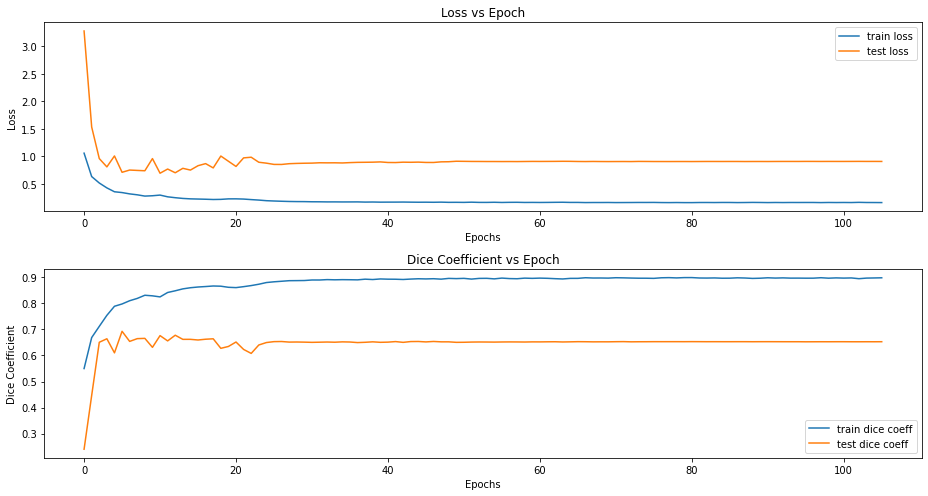

In [ ]:
loss = hist_df['loss']
acc = hist_df['dice_coefficient']
val_loss = hist_df['val_loss']
val_acc = hist_df['val_dice_coefficient']
epoch = hist_df.shape[0]

figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 7))

axes[0].plot(range(0,epoch), loss, label="train loss")
axes[0].plot(range(0,epoch), val_loss, label="test loss")
axes[0].set_title("Loss vs Epoch")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(range(0,epoch), acc, label="train dice coeff")
axes[1].plot(range(0,epoch), val_acc, label="test dice coeff")
axes[1].set_title("Dice Coefficient vs Epoch")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Dice Coefficient")
axes[1].legend()

figure.show()
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


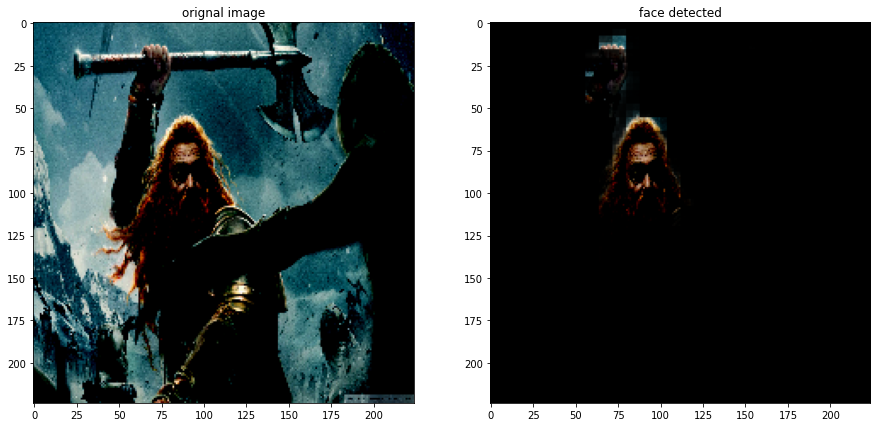

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


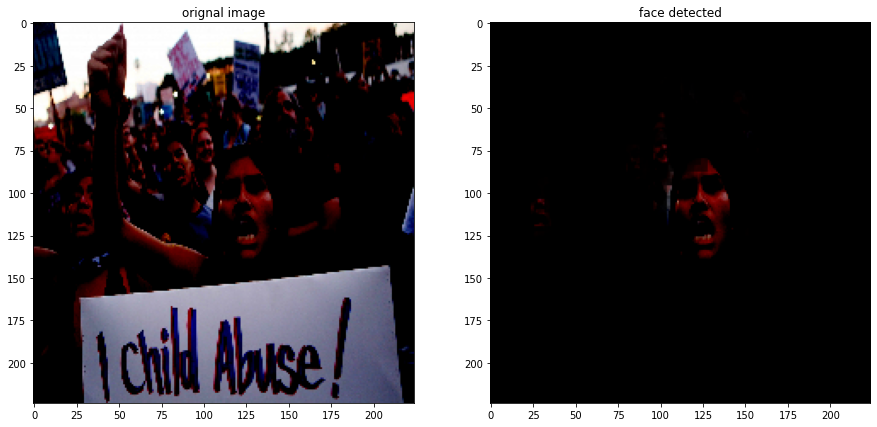

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


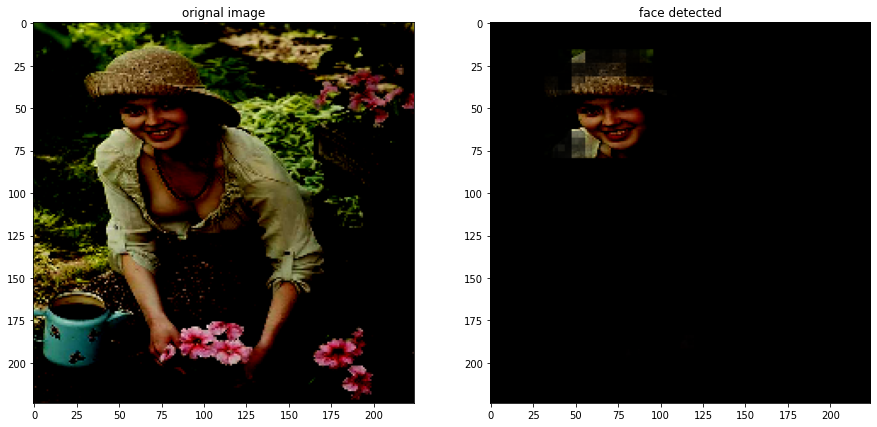

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


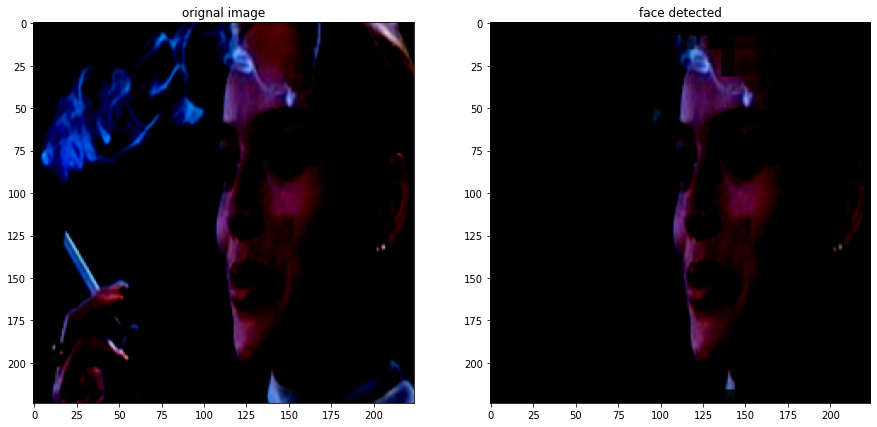

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


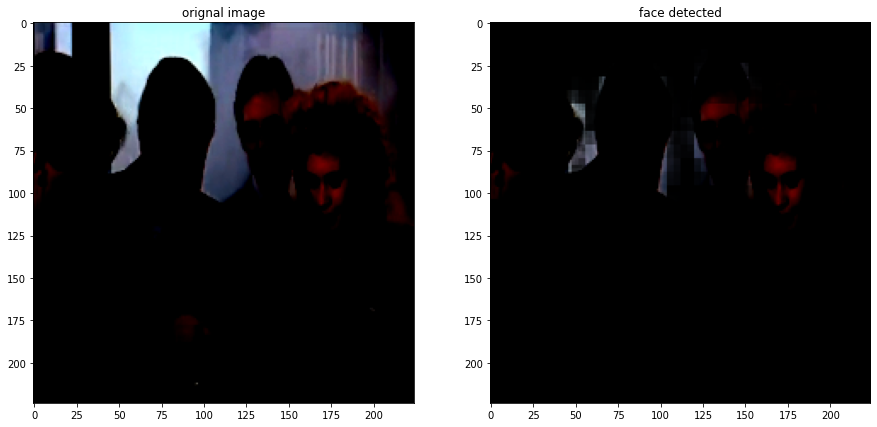

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


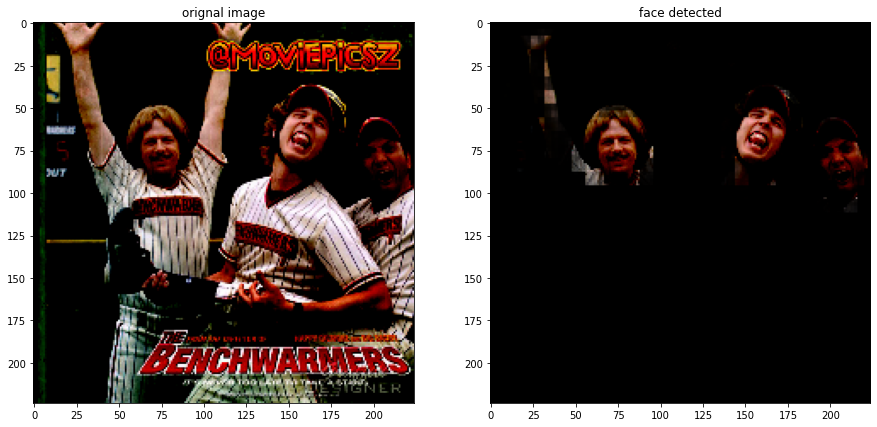

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


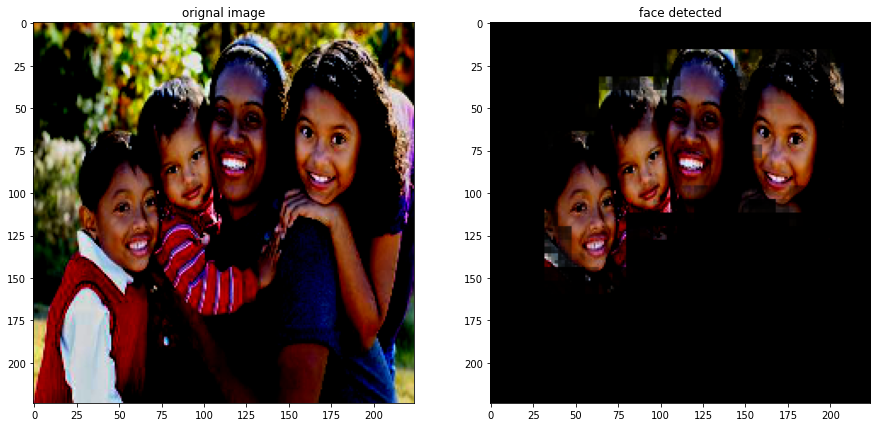

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


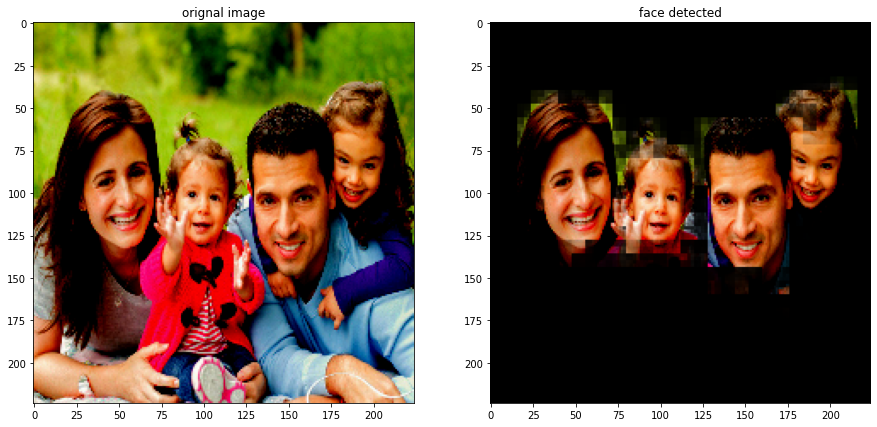

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


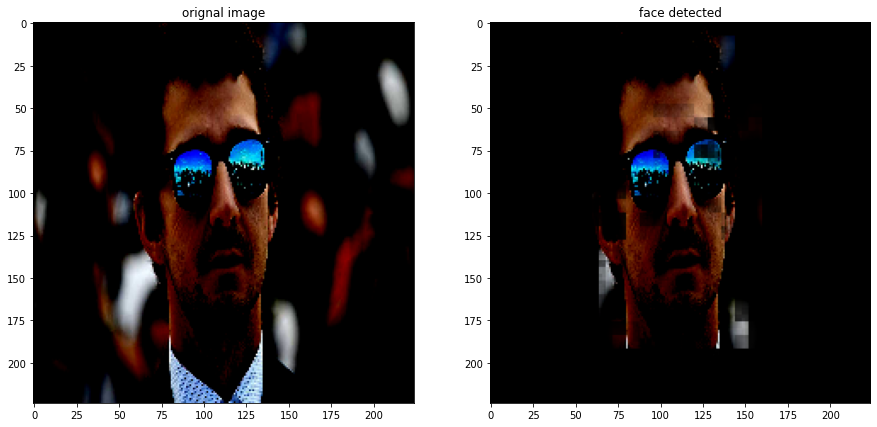

In [ ]:
pred_masks = model.predict(x_val)
for i in range(len(pred_masks)):

  fig,ax = plt.subplots(nrows=1, ncols=2,figsize=(15,7))
  ax[0].imshow(x_val[i])
  ax[0].set_title("orignal image")

  x_val[i][:,:,0] = pred_masks[i]*x_val[i][:,:,0]
  x_val[i][:,:,1] = pred_masks[i]*x_val[i][:,:,1]
  x_val[i][:,:,2] = pred_masks[i]*x_val[i][:,:,2] 

  out_image = x_val[i]

  ax[1].imshow(out_image)
  ax[1].set_title("face detected")
  plt.show()

### We can see some improvement when training the mobilenet layers as well. Although the training process took a few extra epochs but the dice coefficient increased from 0.6416 to 0.6722. 
### We can also see the test images are much more clear.<br><br>
# Now in part 3 we will add convolutions layers to the upsampling part and gradually reduce the number of feature maps. <br>
### In the previous architecture we descend abruptly from 1024 feature maps at the start of the upsampling part to 1 feature map in the output layer. In part 3 we aim to descend gradually and hence we will include 1x1 convolutions to reduce the number of feature maps before every upsampling layer. Other than this everything remains same as before. We still use trainable=True and train the mobile net part as well.

In [60]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(img_h, img_w, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    #taking the featmaps of last conv layer(pointwise conv layer) of each block to concatinate 
    convblock1 = model.get_layer("conv_pw_1_relu").output 
    convblock3 = model.get_layer("conv_pw_3_relu").output
    convblock5 = model.get_layer("conv_pw_5_relu").output
    convblock11 = model.get_layer("conv_pw_11_relu").output
    convblock13 = model.get_layer("conv_pw_13_relu").output

    #upsampling block 13 output and concatinating last layer(pointwise conv layer) of block 11 
    x = Concatenate()([UpSampling2D()(convblock13), convblock11])
    x = Conv2D(1100, kernel_size=1, padding="same", activation="relu")(x)
    x = Conv2D(900, kernel_size=1, padding="same", activation="relu")(x)

    #upsampling result of above output and concatinating last layer(pointwise conv layer) of block 5
    x = Concatenate()([UpSampling2D()(x), convblock5])
    x = Conv2D(900, kernel_size=1, padding="same", activation="relu")(x)
    x = Conv2D(700, kernel_size=1, padding="same", activation="relu")(x)

    #upsampling result of above output and concatinating last layer(pointwise conv layer) of block 3
    x = Concatenate()([UpSampling2D()(x), convblock3])
    x = Conv2D(600, kernel_size=1, padding="same", activation="relu")(x)
    x = Conv2D(500, kernel_size=1, padding="same", activation="relu")(x)

    #upsampling result of above output and concatinating last layer(pointwise conv layer) of block 1
    x = Concatenate()([UpSampling2D()(x), convblock1])
    x = Conv2D(300, kernel_size=1, padding="same", activation="relu")(x)
    x = Conv2D(200, kernel_size=1, padding="same", activation="relu")(x)

    #simple upsampling of above output (no concatination)
    x = UpSampling2D()(x)
    x = Conv2D(100, kernel_size=1, padding="same", activation="relu")(x)

    #applying 1x1 conv with sigmoid activation (each pixel)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    #reshaping
    x = Reshape((img_h, img_w))(x)

    return Model(inputs=model.input, outputs=x)

In [61]:
x_train, x_val, y_train, y_val = train_test_split(X, masks, test_size=9, random_state=1111)

print("training set images: ",x_train.shape)
print("testing set images: ",x_val.shape)

training set images:  (400, 224, 224, 3)
testing set images:  (9, 224, 224, 3)


In [62]:
model = create_model(True)
model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
______________________________________________________________________________________

In [63]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())


def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [64]:
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [65]:
checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor='loss', min_delta=0.01, patience=50, verbose=1, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_dice_coefficient', factor=0.1, patience=20, verbose=1, mode='max', min_delta=0.01, min_lr=1e-7)

In [66]:
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=1000, batch_size=8, verbose=1,callbacks=[stop,reduce_lr,checkpoint])

Epoch 1/1000
50/50 [==============================] - ETA: 0s - loss: 1.1305 - dice_coefficient: 0.5185
Epoch 00001: val_loss improved from inf to 0.94700, saving model to model-0.95.h5
50/50 [==============================] - 13s 267ms/step - loss: 1.1305 - dice_coefficient: 0.5185 - val_loss: 0.9470 - val_dice_coefficient: 0.6232
Epoch 2/1000
50/50 [==============================] - ETA: 0s - loss: 0.6421 - dice_coefficient: 0.6640
Epoch 00002: val_loss did not improve from 0.94700
50/50 [==============================] - 13s 262ms/step - loss: 0.6421 - dice_coefficient: 0.6640 - val_loss: 1.4049 - val_dice_coefficient: 0.5087
Epoch 3/1000
50/50 [==============================] - ETA: 0s - loss: 0.5527 - dice_coefficient: 0.7025
Epoch 00003: val_loss improved from 0.94700 to 0.88492, saving model to model-0.88.h5
50/50 [==============================] - 13s 266ms/step - loss: 0.5527 - dice_coefficient: 0.7025 - val_loss: 0.8849 - val_dice_coefficient: 0.5349
Epoch 4/1000
50/50 [=====

In [67]:
model.save("/content/drive/My Drive/Colab Notebooks/model.h5")
model.save_weights("/content/drive/My Drive/Colab Notebooks/model_weights.h5")

hist_df = pd.DataFrame(model.history.history) 
hist_df.to_csv('/content/drive/My Drive/Colab Notebooks/model_history.csv',index=False)

In [68]:
model.evaluate(x_val, y_val)

1/1 [==============================] - 0s 2ms/step - loss: 0.8985 - dice_coefficient: 0.6975


[0.8984922766685486, 0.6975142359733582]

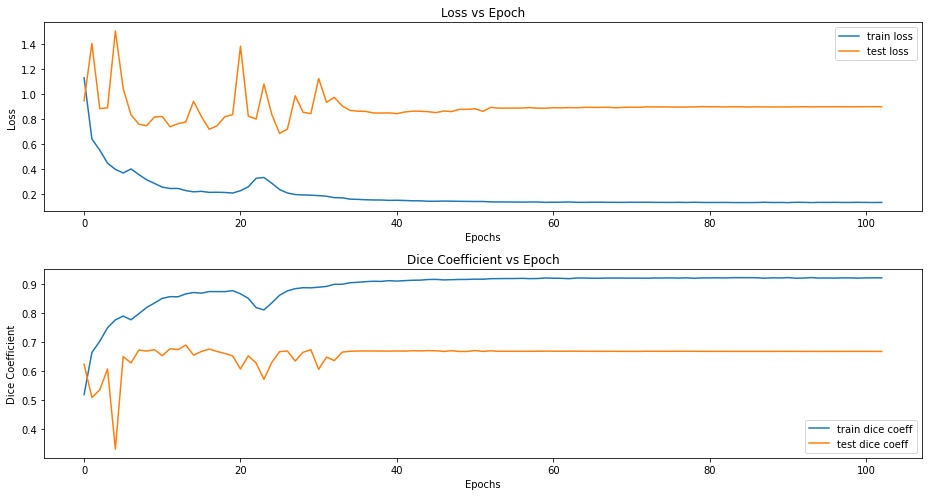

In [69]:
loss = hist_df['loss']
acc = hist_df['dice_coefficient']
val_loss = hist_df['val_loss']
val_acc = hist_df['val_dice_coefficient']
epoch = hist_df.shape[0]

figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 7))

axes[0].plot(range(0,epoch), loss, label="train loss")
axes[0].plot(range(0,epoch), val_loss, label="test loss")
axes[0].set_title("Loss vs Epoch")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(range(0,epoch), acc, label="train dice coeff")
axes[1].plot(range(0,epoch), val_acc, label="test dice coeff")
axes[1].set_title("Dice Coefficient vs Epoch")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Dice Coefficient")
axes[1].legend()

figure.show()
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


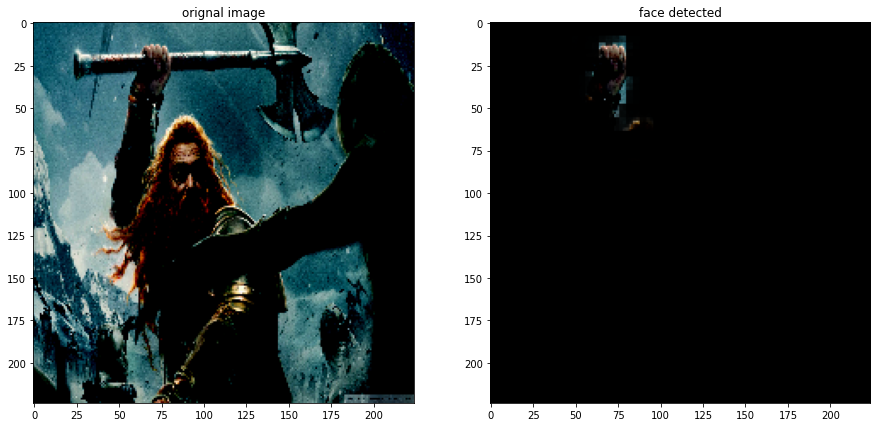

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


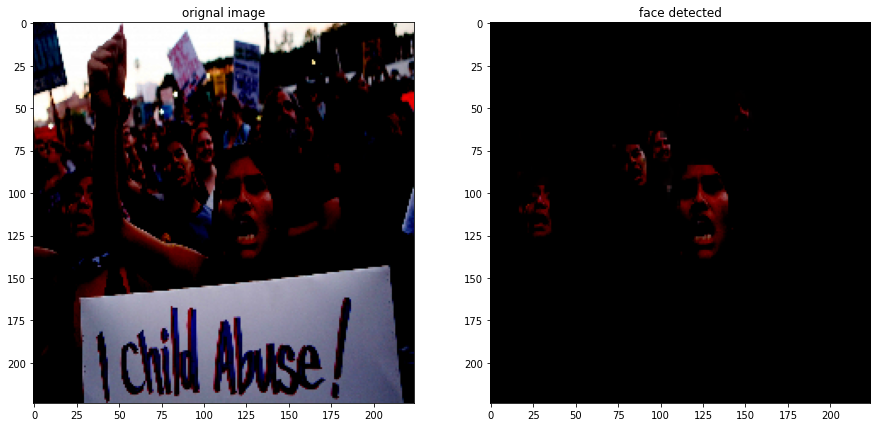

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


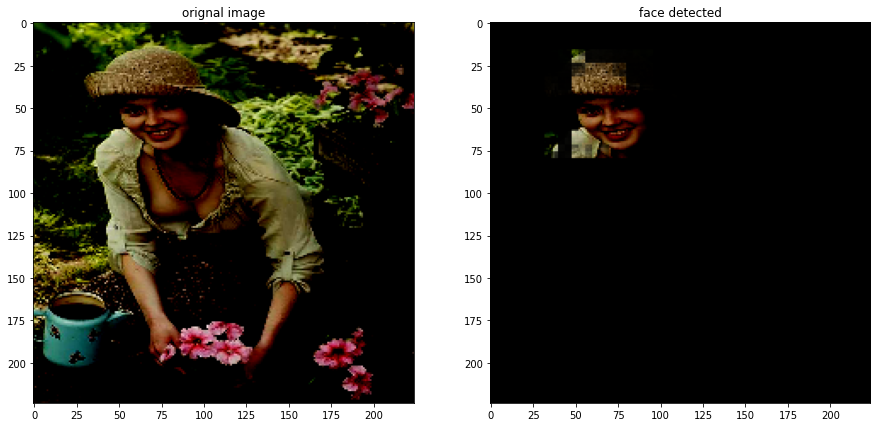

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


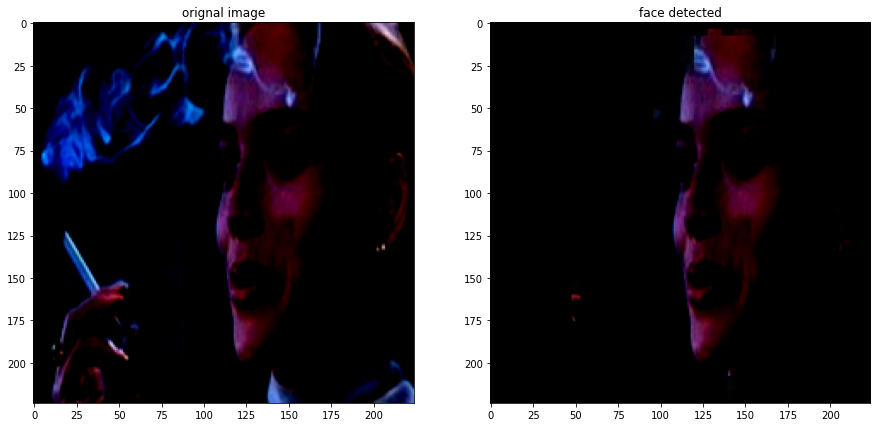

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


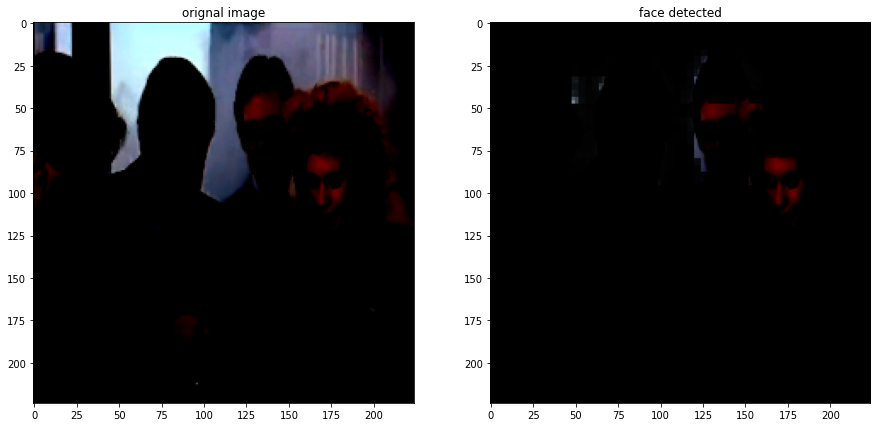

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


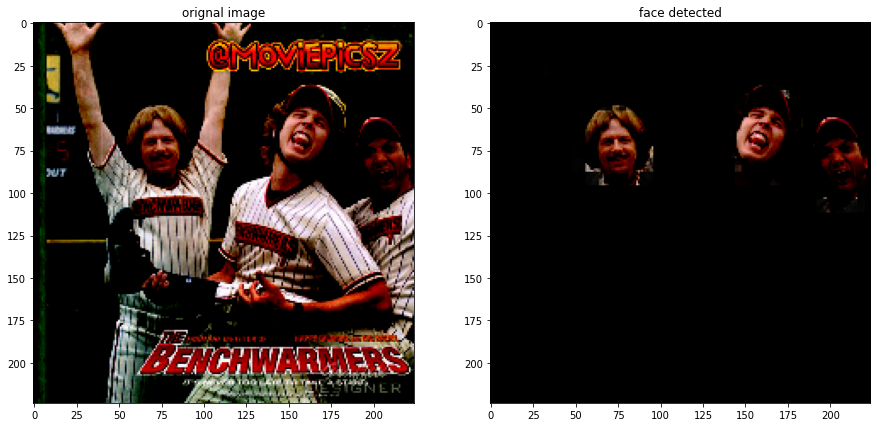

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


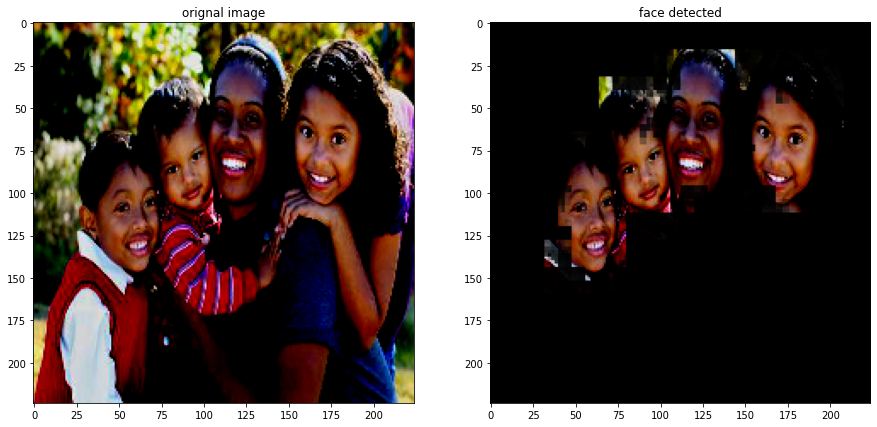

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


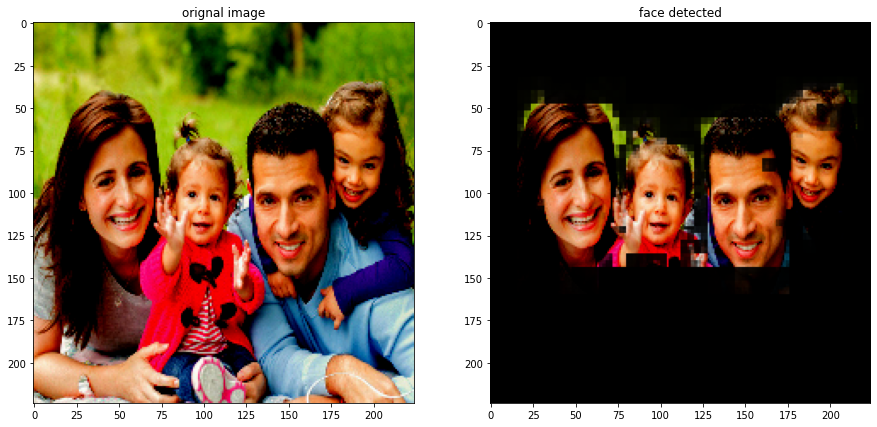

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


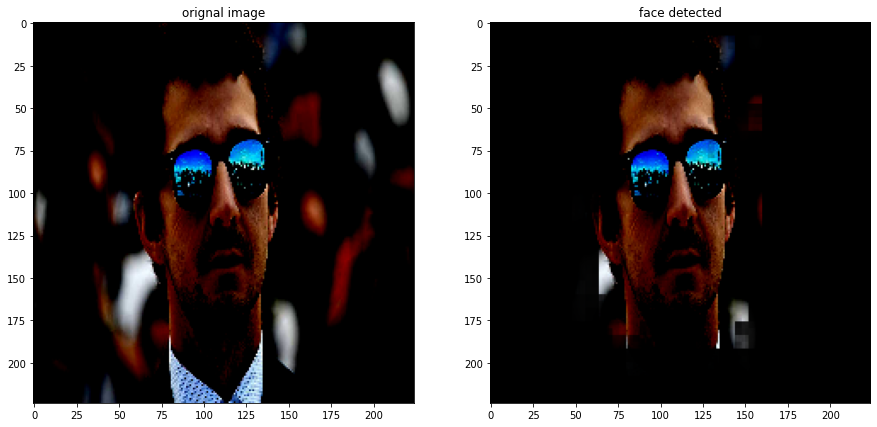

In [70]:
pred_masks = model.predict(x_val)
for i in range(len(pred_masks)):

  fig,ax = plt.subplots(nrows=1, ncols=2,figsize=(15,7))
  ax[0].imshow(x_val[i])
  ax[0].set_title("orignal image")

  x_val[i][:,:,0] = pred_masks[i]*x_val[i][:,:,0]
  x_val[i][:,:,1] = pred_masks[i]*x_val[i][:,:,1]
  x_val[i][:,:,2] = pred_masks[i]*x_val[i][:,:,2] 

  out_image = x_val[i]

  ax[1].imshow(out_image)
  ax[1].set_title("face detected")
  plt.show()

## So we have further improved the dice coefficient increased from 0.6722 to 0.6975 by gradually reducing the number of feature maps. Loss also decreased from 0.9090 to 0.8985.